### VAE with convolutional layers

When moving to more complex image dataset, it's useful to use convolutional layers.

Here we move from the 28x28 MNIST dataset to the 64x64 pixels moving MNIST dataset. We decomposes the videos into a set of images to ahve a simple images dataset. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# parameters
batch_size = 128
learning_rate = 1e-3
num_epochs = 50

img_size = 64


cuda


In [2]:
data = np.load('data/bouncing_mnist_test.npy') # download here http://www.cs.toronto.edu/~nitish/unsupervised_video/
data = data.reshape((200000,1,64,64)) # we split the 10000 video of 20 frames into 200000 images of 64x64 pixels
data = data / 255 # normalize pixel value between 0 and 1, like the MNIST dataset

# the data is shuffled when loaded
train_loader = torch.utils.data.DataLoader(
                 dataset=data,
                 batch_size=batch_size,
                 shuffle=True)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Decoder(nn.Module):
    """ VAE decoder """
    def __init__(self, img_channels, latent_size):
        super(Decoder, self).__init__()
        self.latent_size = latent_size
        self.img_channels = img_channels

        self.fc1 = nn.Linear(latent_size, 1024)
        self.deconv1 = nn.ConvTranspose2d(1024, 128, 5, stride=2)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(32, img_channels, 6, stride=2)

    def forward(self, x): # pylint: disable=arguments-differ
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        reconstruction = F.sigmoid(self.deconv4(x))
        return reconstruction

class Encoder(nn.Module): # pylint: disable=too-many-instance-attributes
    """ VAE encoder """
    def __init__(self, img_channels, latent_size):
        super(Encoder, self).__init__()
        self.latent_size = latent_size
        #self.img_size = img_size
        self.img_channels = img_channels

        self.conv1 = nn.Conv2d(img_channels, 32, 4, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2)

        self.fc_mu = nn.Linear(2*2*256, latent_size)
        self.fc_logsigma = nn.Linear(2*2*256, latent_size)


    def forward(self, x): # pylint: disable=arguments-differ
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)

        mu = self.fc_mu(x)
        logsigma = self.fc_logsigma(x)

        return mu, logsigma

class VAE(nn.Module):
    """ Variational Autoencoder """
    def __init__(self, img_channels, latent_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(img_channels, latent_size)
        self.decoder = Decoder(img_channels, latent_size)

    def forward(self, x): # pylint: disable=arguments-differ
        mu, logsigma = self.encoder(x)
        sigma = logsigma.exp()
        eps = torch.randn_like(sigma)
        z = eps.mul(sigma).add_(mu)

        recon_x = self.decoder(z)
        return recon_x, mu, logsigma

def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

In [10]:
net = VAE(1,32).to(device)
print('nb of params : {}'.format(count_parameters(net)))

nb of params : 4345217


In [11]:
# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [12]:
from tqdm import tqdm

for epoch in range(num_epochs):

    pbar = tqdm(train_loader)
    pbar.set_description("epoch %s/ loss=? " % str(epoch+1))
    
    for data in pbar:
        
        imgs = data
        imgs = imgs.to(device).float()
        
        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = net(imgs)
        
        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = -0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp())
        loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence
        
        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description("epoch "+str(epoch+1)+"/"+str(num_epochs)+"/ loss= "+str(loss.cpu().detach().numpy()) )
        
        

epoch 1/ loss=? :   0%|          | 0/1563 [00:00<?, ?it/s]c:\Users\fphub\mambaforge\envs\iblenv\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
epoch 4/50/ loss= 33084.938:  37%|███▋      | 586/1563 [00:49<01:22, 11.84it/s]


KeyboardInterrupt: 

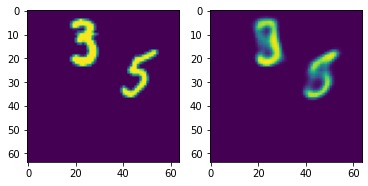

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import random

net.eval()
with torch.no_grad():
    for data in random.sample(list(train_loader), 1):
        imgs = data
        imgs = imgs.to(device).float()
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        out, mu, logVAR = net(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))

In [16]:
# saving a model
torch.save(net.state_dict(), 'model/vae_moving_digits.pt')

In [6]:
# loading a model
net = VAE().to(device)
net.load_state_dict(torch.load('model/vae_moving_digits.pt'))
net.eval()

RuntimeError: Error(s) in loading state_dict for VAE:
	Missing key(s) in state_dict: "encFC_mean.weight", "encFC_mean.bias", "encFC_var.weight", "encFC_var.bias". 
	Unexpected key(s) in state_dict: "encFC1.weight", "encFC1.bias", "encFC2.weight", "encFC2.bias". 
	size mismatch for encConv1.weight: copying a param with shape torch.Size([16, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 1, 5, 5]).
	size mismatch for encConv1.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encConv2.weight: copying a param with shape torch.Size([32, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 32, 5, 5]).
	size mismatch for encConv2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for encFC.weight: copying a param with shape torch.Size([256, 100352]) from checkpoint, the shape in current model is torch.Size([512, 12544]).
	size mismatch for encFC.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for decFC.weight: copying a param with shape torch.Size([256, 16]) from checkpoint, the shape in current model is torch.Size([512, 32]).
	size mismatch for decFC.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for decFC1.weight: copying a param with shape torch.Size([100352, 256]) from checkpoint, the shape in current model is torch.Size([9216, 512]).
	size mismatch for decFC1.bias: copying a param with shape torch.Size([100352]) from checkpoint, the shape in current model is torch.Size([9216]).
	size mismatch for decConv1.weight: copying a param with shape torch.Size([32, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 32, 5, 5]).
	size mismatch for decConv1.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decConv2.weight: copying a param with shape torch.Size([16, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([32, 1, 5, 5]).

C:\Users\fphub\AppData\Local\Temp\ipykernel_22344\1660445907.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  reconstruct_rd_img,_,r_sigma = net(torch.tensor([[rd_img]]).to(device))


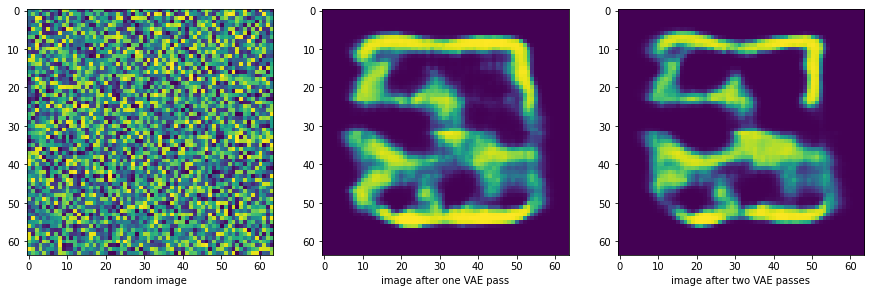

sigma after one pass : [[-3.6202803 -3.235823  -4.064928  -3.7384474 -4.0355635 -3.6045723
  -3.972793  -3.7665539 -3.8922074 -4.0795627 -3.8715398 -3.8485076
  -3.9732726 -4.0882845 -3.6604836 -3.835464  -4.2331276 -3.8528926
  -3.5890865 -3.404805  -4.182339  -3.440964  -3.6822238 -3.8718874
  -3.9055493 -3.8562407 -3.774805  -4.1118245 -3.430654  -3.236515
  -3.8807113 -3.9704146]]
sigma after two passes : [[-3.2931082 -2.8634717 -3.4695506 -3.29539   -3.5152504 -3.2766478
  -3.6540823 -3.3486333 -3.5224736 -3.6743467 -3.2938523 -3.3727322
  -3.3192768 -3.4959075 -3.3774002 -3.322426  -3.420932  -3.2853675
  -2.911025  -3.18231   -3.92613   -3.0860665 -3.184185  -3.5093067
  -3.606555  -3.2635703 -3.1919358 -3.3900828 -3.0184264 -2.9570715
  -3.3221745 -3.5660877]]


In [17]:
rd_img = np.random.uniform(size=(img_size,img_size)).astype(np.float32)

reconstruct_rd_img,_,r_sigma = net(torch.tensor([[rd_img]]).to(device))
reconstruct_rd_img = reconstruct_rd_img.detach().cpu().numpy()[0,0]

reconstruct_reconstruct_rd_img,_,r_r_sigma = net(torch.tensor([[reconstruct_rd_img]]).to(device))
reconstruct_reconstruct_rd_img = reconstruct_reconstruct_rd_img.detach().cpu().numpy()[0,0]

f = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rd_img)
plt.xlabel('random image')

plt.subplot(1,3,2)
plt.imshow(reconstruct_rd_img)
plt.xlabel('image after one VAE pass')

plt.subplot(1,3,3)
plt.imshow(reconstruct_reconstruct_rd_img)
plt.xlabel('image after two VAE passes')

plt.show()

print('sigma after one pass : {}'.format(r_sigma.detach().cpu().numpy()))
print('sigma after two passes : {}'.format(r_r_sigma.detach().cpu().numpy()))